In [15]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [17]:
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [19]:
ts = data['#Passengers']

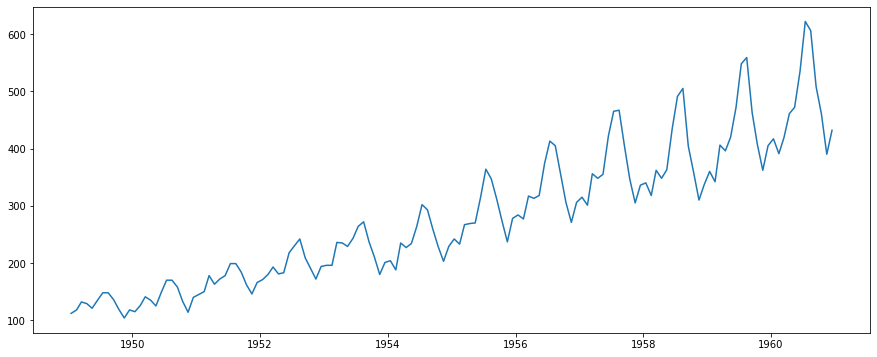

In [20]:
plt.plot(ts)

In [21]:
ts_log = np.log(ts)

In [28]:
def test_stationary(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    
    org = plt.plot(timeseries, color= 'blue', label='Original')
    mean = plt.plot(rolmean, color= "Red", label= 'Rolling mean')
    std = plt.plot(rolstd, color= 'Black', label= 'Rolling std')
    plt.legend('Rolling mean and std deviation')
    plt.show(block=False)
    
    print('result of dicky fuller test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lag used', 'Number of observations used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical  value (%s)'%key] = value
    print(dfoutput)
    
                                             

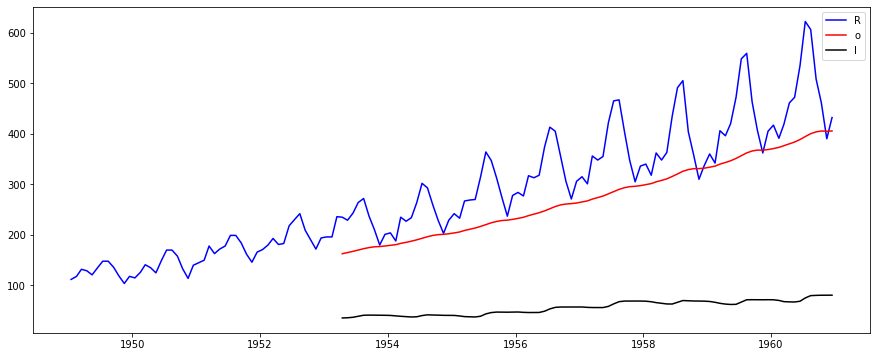

result of dicky fuller test:
Test Statistic                   0.815369
p-value                          0.991880
#lag used                       13.000000
Number of observations used    130.000000
Critical  value (1%)            -3.481682
Critical  value (5%)            -2.884042
Critical  value (10%)           -2.578770
dtype: float64


In [29]:
test_stationary(data['#Passengers'])

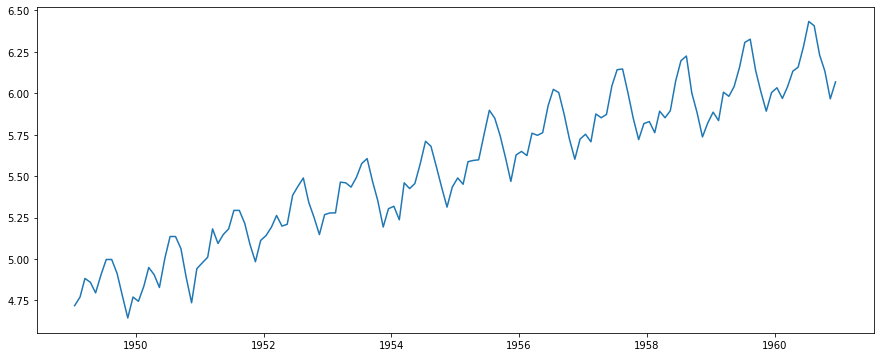

In [30]:
plt.plot(ts_log)

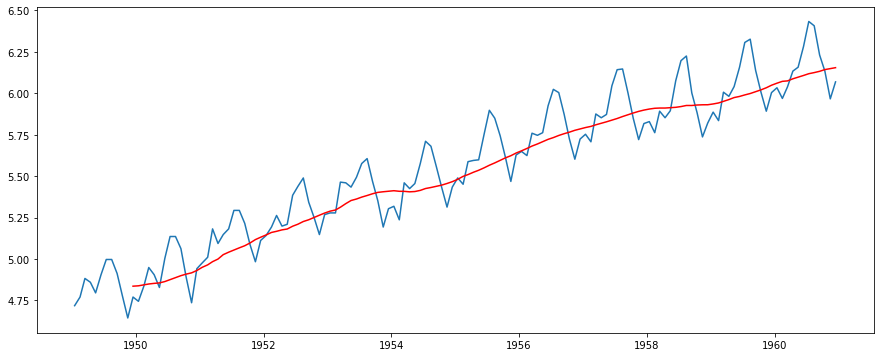

In [33]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color= 'red')

In [34]:
ts_log_mv_diff = ts_log -movingAverage
ts_log_mv_diff.head(12)

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64

In [35]:
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

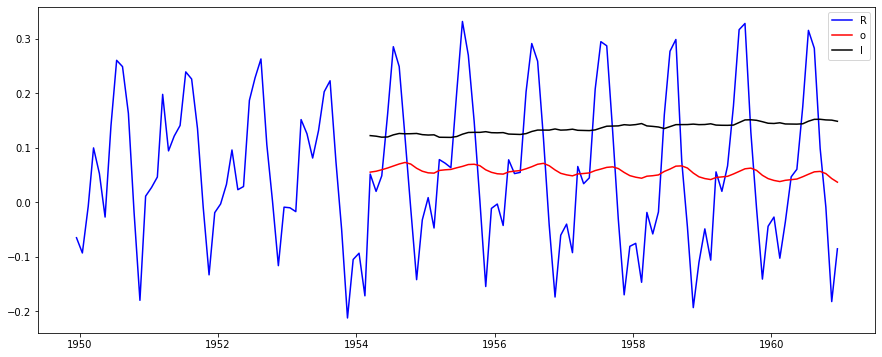

result of dicky fuller test:
Test Statistic                  -3.162908
p-value                          0.022235
#lag used                       13.000000
Number of observations used    119.000000
Critical  value (1%)            -3.486535
Critical  value (5%)            -2.886151
Critical  value (10%)           -2.579896
dtype: float64


In [36]:
test_stationary(ts_log_mv_diff)

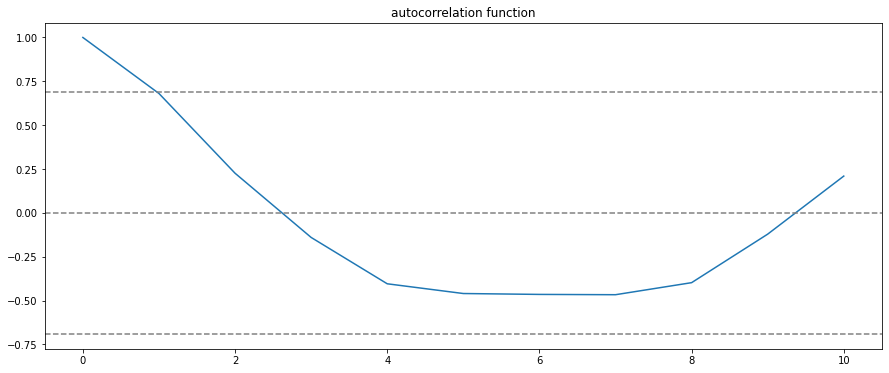

In [39]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='grey')
plt.title('autocorrelation function')
plt.show()

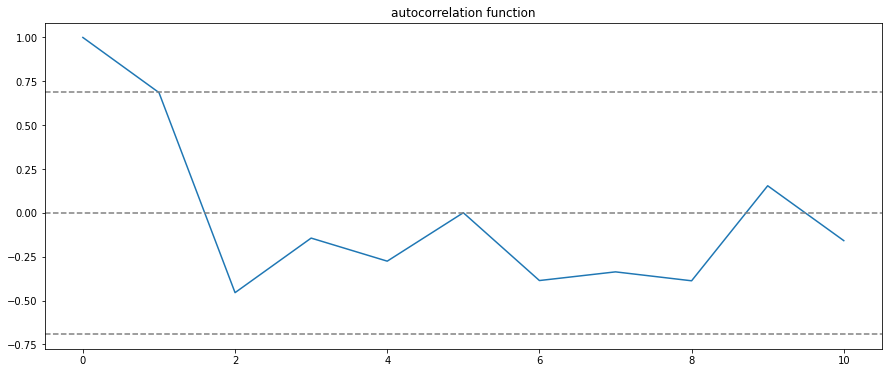

In [42]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--', color='grey')
plt.title('autocorrelation function')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

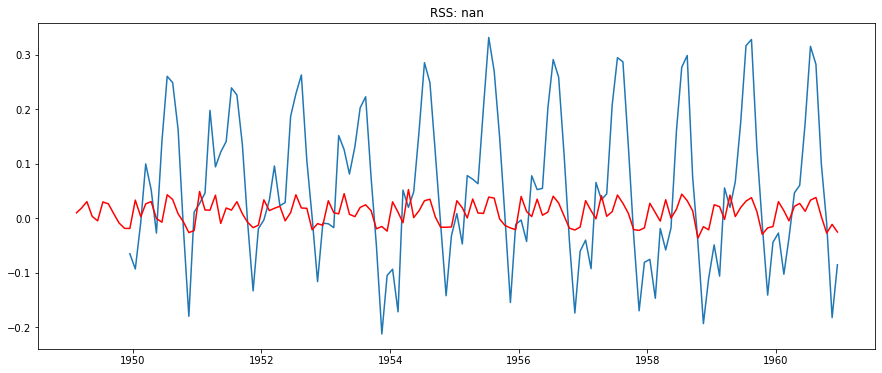

In [43]:
model = ARIMA(ts_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [44]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [45]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [47]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

TypeError: unsupported operand type(s) for /: 'str' and 'int'

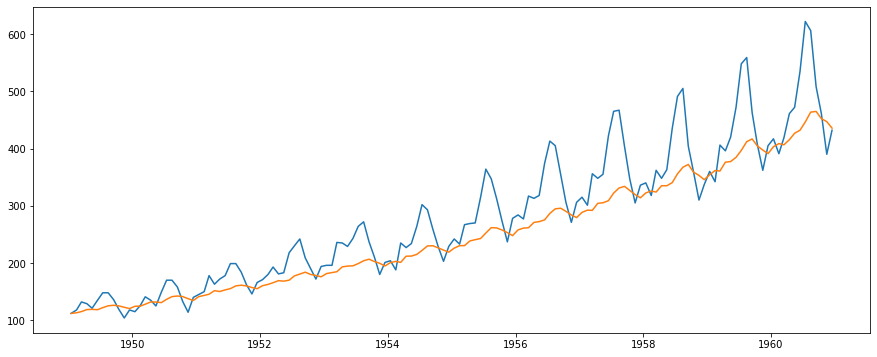

In [48]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum(predictions_ARIMA-ts)**2)/len(ts))